# 3.2 ロボットの動き
## 3.2.1 世界座標系と描画

In [1]:
import matplotlib.pyplot as plt
class World:
    def __init__(self, debug=False):
        self.objects=[]
        self.debug=debug
        
    def append(self, obj):
        self.objects.append(obj)
        
    def draw(self):
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_xlabel("X", fontsize=20)
        ax.set_ylabel("Y", fontsize=20)
            
        for obj in self.objects:
            obj.draw(ax)
        plt.show()
        

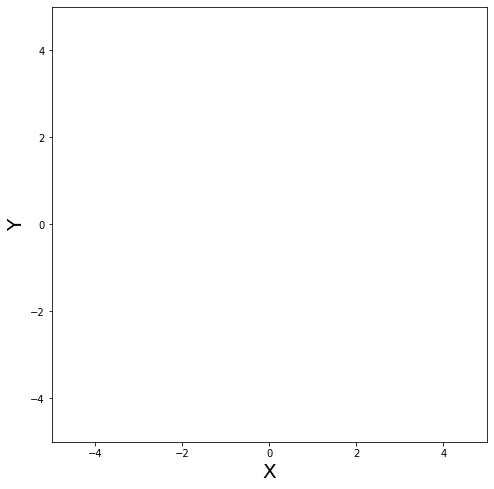

In [2]:
world=World()
world.draw()

## 3.2.2 ロボットの姿勢と描画

位置と向きをあわせて「姿勢」とする。あるいは制御の用語で「状態」と呼ぶ。

In [3]:
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np

In [4]:
class IdealRobot:
    def __init__(self, pose, color="black"):
        self.pose=pose
        self.r=0.2
        self.color=color
        
    def draw(self, ax):
        x, y, theta=self.pose
        xn=x + self.r*math.cos(theta)
        yn=y+self.r*math.sin(theta)
        ax.plot([x, xn], [y, yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color)
        ax.add_patch(c)

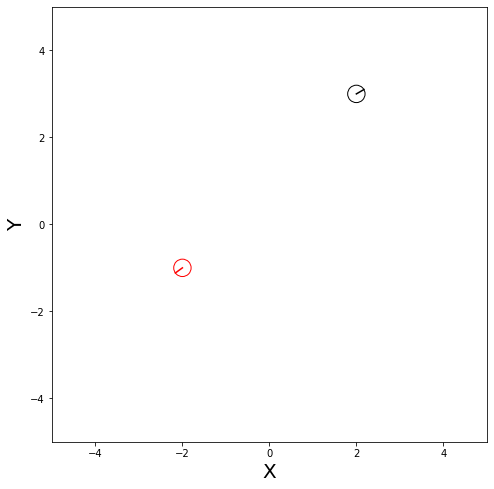

In [5]:
world=World()
robot1=IdealRobot(np.array([2, 3, math.pi/6]).T)
robot2=IdealRobot(np.array([-2, -1, math.pi/5*6]).T, "red")
world.append(robot1)
world.append(robot2)
world.draw()

## 3.2.3 アニメーションの導入

In [17]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
%matplotlib notebook
%matplotlib notebook

In [26]:
import matplotlib.pyplot as plt
class World:
    def __init__(self, debug=False):
        self.objects=[]
        self.debug=debug
        
    def append(self, obj):
        self.objects.append(obj)
        
    def draw(self):
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_xlabel("X", fontsize=20)
        ax.set_ylabel("Y", fontsize=20)
        elems=[]
        if self.debug:
            for i in range(1000):
                self.one_step(i, elems, ax)
        else:
            self.ani=anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=10, interval=1000, repeat=False)
            plt.show()
                    
    def one_step(self, i, elems, ax):
        while elems:
            elems.pop().remove()
        elems.append(ax.text(-4.4, 4.5, "t=" + str(i), fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)

In [27]:
class IdealRobot:
    def __init__(self, pose, color="black"):
        self.pose=pose
        self.r=0.2
        self.color=color
        
    def draw(self, ax, elems):
        x, y, theta=self.pose
        xn=x + self.r*math.cos(theta)
        yn=y+self.r*math.sin(theta)
        elems += ax.plot([x, xn], [y, yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color)
        elems.append(ax.add_patch(c))

<IPython.core.display.Javascript object>


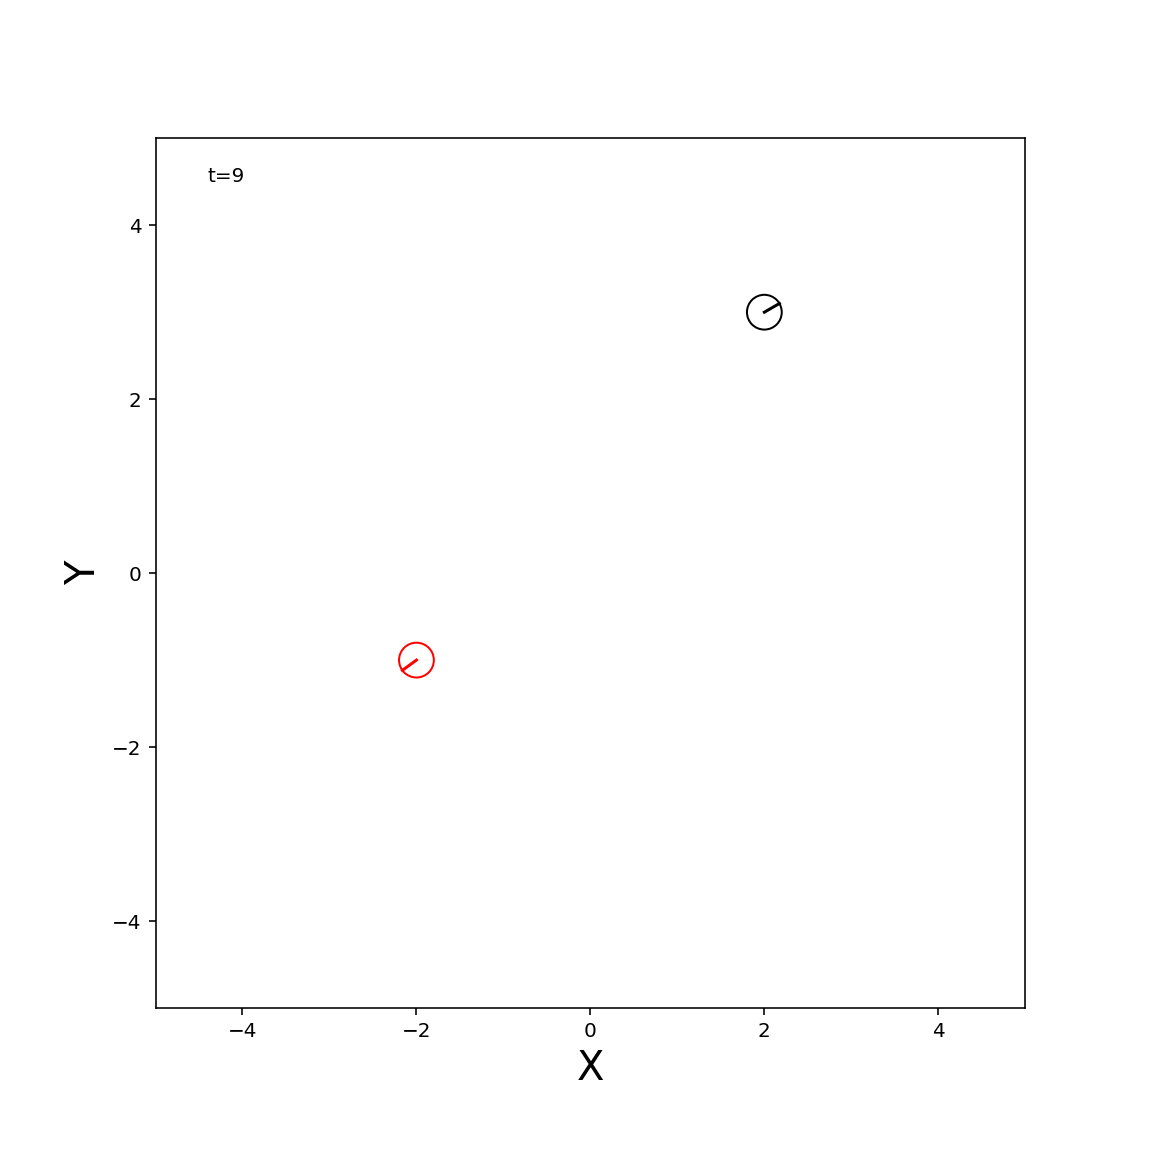

In [30]:
world=World(debug=False)
robot1=IdealRobot(np.array([2, 3, math.pi/6]).T)
robot2=IdealRobot(np.array([-2, -1, math.pi/5*6]).T, "red")
world.append(robot1)
world.append(robot2)
world.draw()

## 3.2.4 ロボットの運動と状態方程式
ある時刻にロボットが動いたときに次のステップでロボットの姿勢がどのようになるか考える。
    ロボットに与える司令は、前方方向への速度 $\nu[m/s]$とロボット中心の角速度$\omega[rad/s]$とし、二つをまとめて$u = (\nu \  \omega)^\mathrm{T}$とする。

In [36]:
class IdealRobot:
    def __init__(self, pose, color="black"):
        self.pose=pose
        self.r=0.2
        self.color=color
        
    def draw(self, ax, elems):
        x, y, theta=self.pose
        xn=x + self.r*math.cos(theta)
        yn=y+self.r*math.sin(theta)
        elems += ax.plot([x, xn], [y, yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color)
        elems.append(ax.add_patch(c))
        
    @classmethod
    def state_transition(cls, nu, omega, time, pose):
        t0=pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array([nu*math.cos(t0), 
                                                    nu*math.sin(t0),
                                                   omega] )*time
        else:
            return pose + np.array([
                nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)),
                nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                omega*time
            ])

In [34]:
IdealRobot.state_transition(0.1, 0.0, 1.0, np.array([0,0,0]).T)

array([0.1, 0. , 0. ])

In [37]:
IdealRobot.state_transition(0.1, 10.0/180*math.pi, 9.0, np.array([0,0,0]).T)

array([0.5729578 , 0.5729578 , 1.57079633])

In [39]:
IdealRobot.state_transition(0.1, 10.0/180*math.pi, 18.0, np.array([0,0,0]).T)

array([7.01670930e-17, 1.14591559e+00, 3.14159265e+00])

## 3.2.5 エージェントの実装

In [40]:
class Agent:
    def __init__(self, nu, omega):
        self.nu=nu
        self.omega=omega
    def decision(self, observation=None):
        return self.nu, self.omega

In [64]:
class IdealRobot:
    def __init__(self, pose, agent=None, color="black"):
        self.pose=pose
        self.r=0.2
        self.color=color
        self.agent=agent
        self.poses=[pose]
        
    def draw(self, ax, elems):
        x, y, theta=self.pose
        xn=x + self.r*math.cos(theta)
        yn=y+self.r*math.sin(theta)
        elems += ax.plot([x, xn], [y, yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color)
        elems.append(ax.add_patch(c))
        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
        
    @classmethod
    def state_transition(cls, nu, omega, time, pose):
        t0=pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array([nu*math.cos(t0), 
                                                    nu*math.sin(t0),
                                                   omega] )*time
        else:
            return pose + np.array([
                nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)),
                nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                omega*time
            ])
        
    def one_step(self, time_interval):
        if not self.agent: 
            return
        nu, omega = self.agent.decision()
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)

<IPython.core.display.Javascript object>


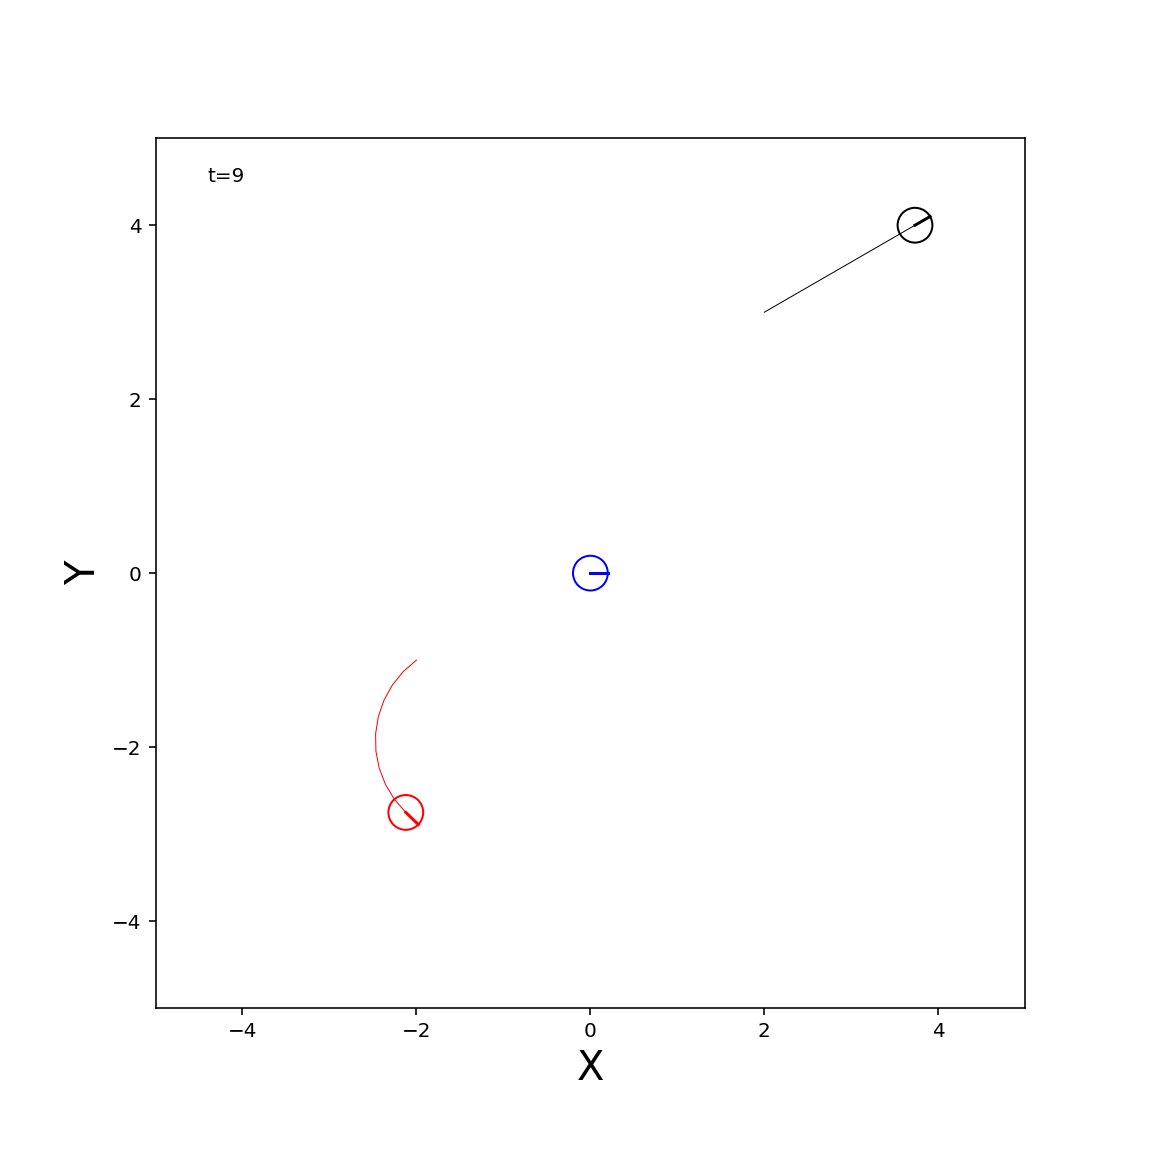

In [62]:
world=World()
straight=Agent(0.2, 0.0)
circling=Agent(0.2, 10.0/180*math.pi)
robot1=IdealRobot(np.array([2, 3, math.pi/6]).T, straight)
robot2=IdealRobot(np.array([-2, -1, math.pi/5*6]).T, circling, "red")
robot3=IdealRobot(np.array([0, 0, 0]).T, color="blue")
world.append(robot1)
world.append(robot2)
world.append(robot3)
world.draw()

In [65]:
import matplotlib.pyplot as plt
class World:
    def __init__(self, debug=False):
        self.objects=[]
        self.debug=debug
        
    def append(self, obj):
        self.objects.append(obj)
        
    def draw(self):
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_xlabel("X", fontsize=20)
        ax.set_ylabel("Y", fontsize=20)
        elems=[]
        if self.debug:
            for i in range(1000):
                self.one_step(i, elems, ax)
        else:
            self.ani=anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=20, interval=1000, repeat=False)
            plt.show()
                    
    def one_step(self, i, elems, ax):
        while elems:
            elems.pop().remove()
        elems.append(ax.text(-4.4, 4.5, "t=" + str(i), fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"):
                obj.one_step(1.0)

<IPython.core.display.Javascript object>


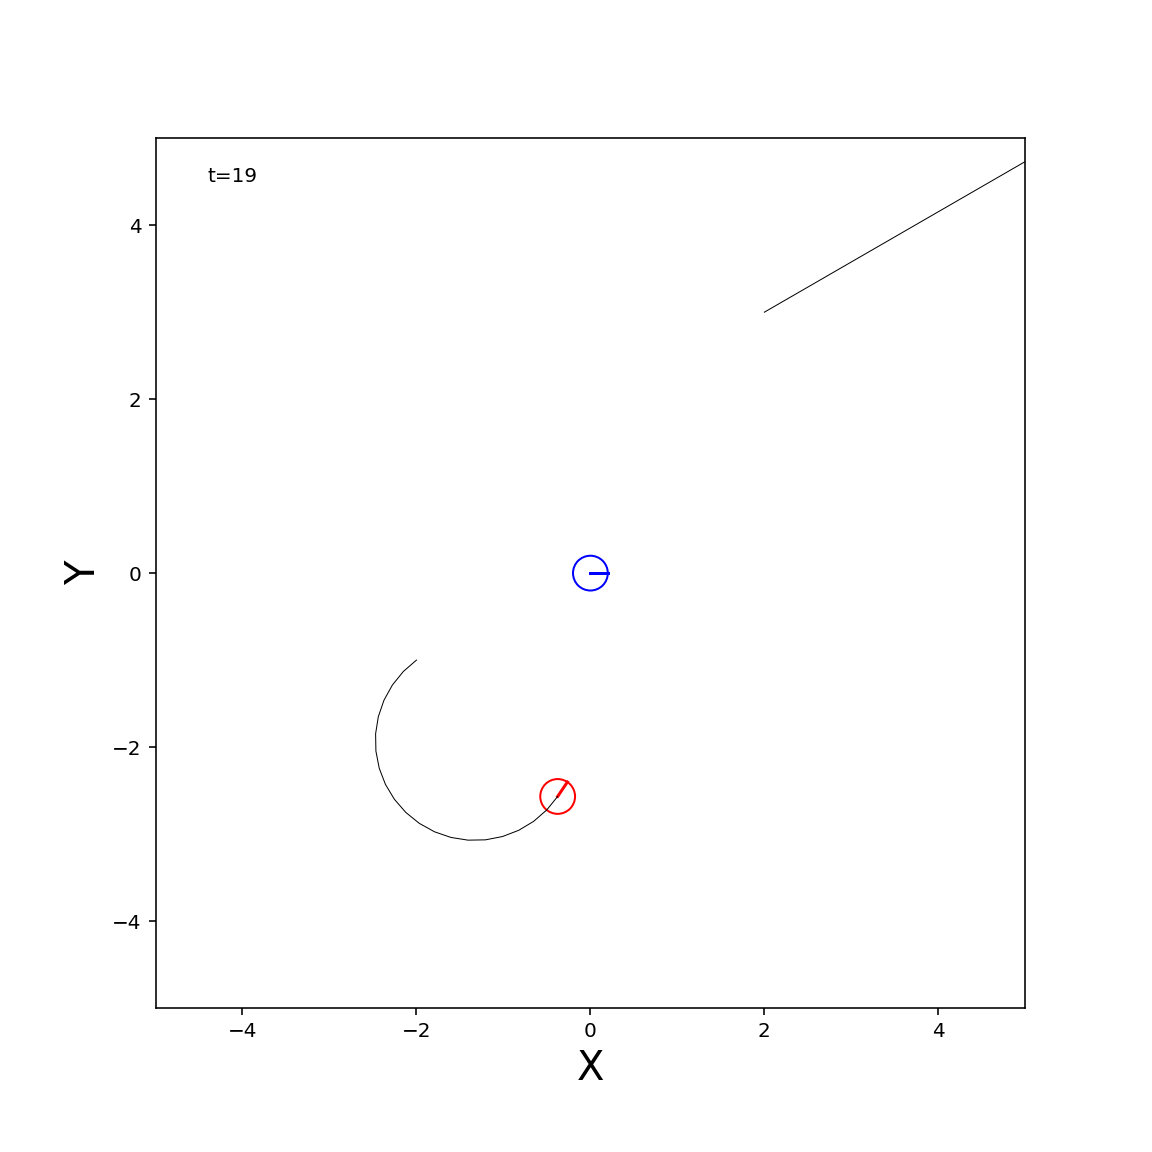

In [66]:
world=World()
straight=Agent(0.2, 0.0)
circling=Agent(0.2, 10.0/180*math.pi)
robot1=IdealRobot(np.array([2, 3, math.pi/6]).T, straight)
robot2=IdealRobot(np.array([-2, -1, math.pi/5*6]).T, circling, "red")
robot3=IdealRobot(np.array([0, 0, 0]).T, color="blue")
world.append(robot1)
world.append(robot2)
world.append(robot3)
world.draw()

## 3.2.6 離散時刻の設定

In [75]:
import matplotlib.pyplot as plt
class World:
    def __init__(self, time_span, time_interval, debug=False):
        self.objects=[]
        self.debug=debug
        self.time_span=time_span
        self.time_interval=time_interval
        
    def append(self, obj):
        self.objects.append(obj)
        
    def draw(self):
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_xlabel("X", fontsize=20)
        ax.set_ylabel("Y", fontsize=20)
        elems=[]
        if self.debug:
            for i in range(1000):
                self.one_step(i, elems, ax)
        else:
            self.ani=anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax), frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            plt.show()
                    
    def one_step(self, i, elems, ax):
        while elems:
            elems.pop().remove()
        time_str="time=%.2f[s]"%(self.time_interval*i)
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"):
                obj.one_step(self.time_interval)

<IPython.core.display.Javascript object>


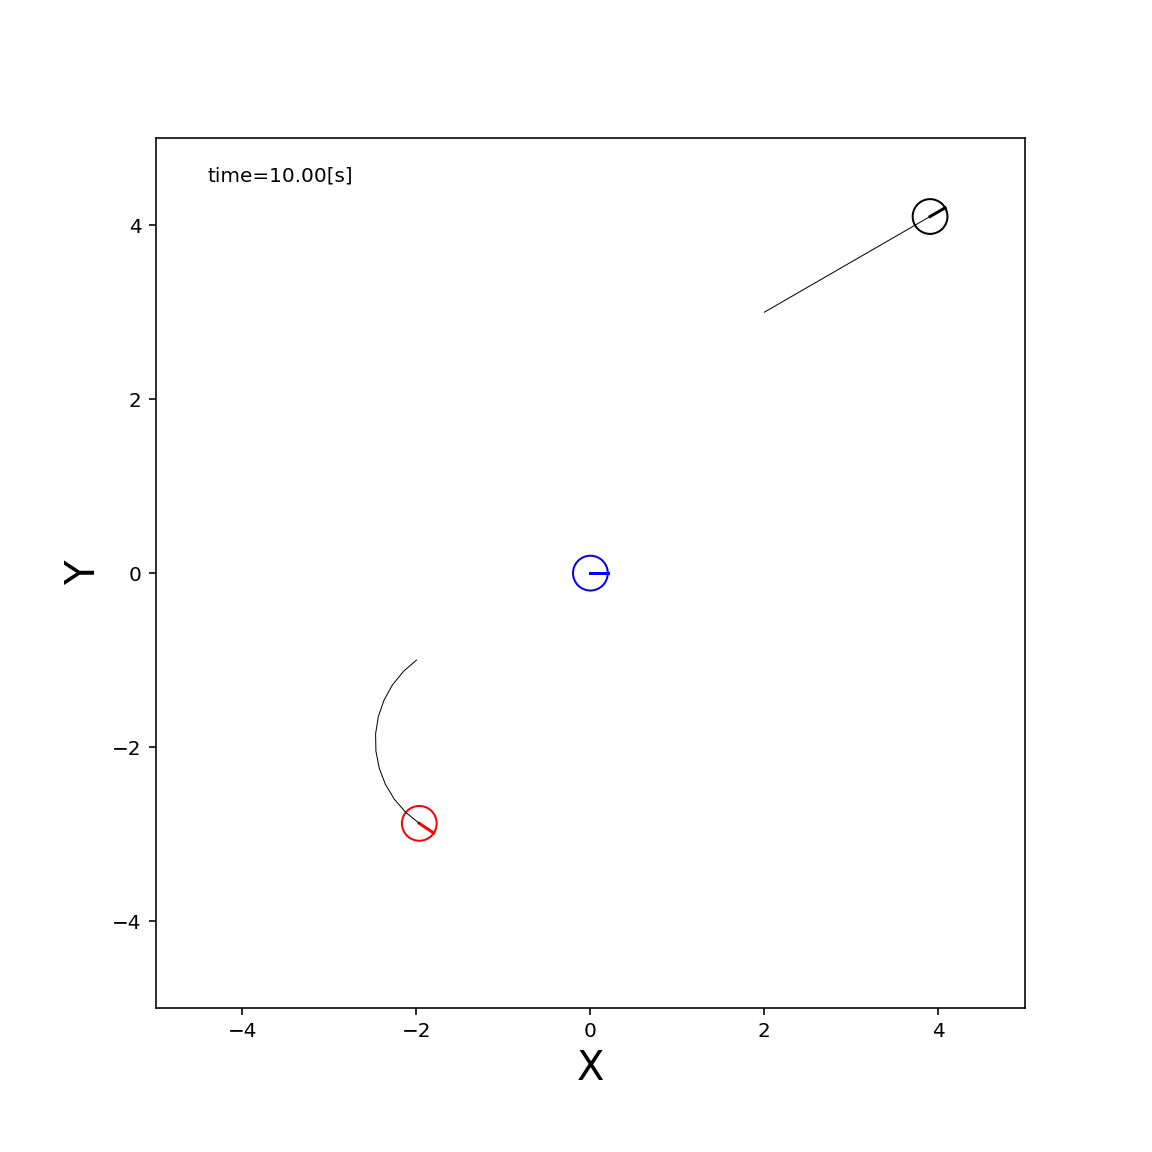

In [76]:
world=World(10, 1)
straight=Agent(0.2, 0.0)
circling=Agent(0.2, 10.0/180*math.pi)
robot1=IdealRobot(np.array([2, 3, math.pi/6]).T, straight)
robot2=IdealRobot(np.array([-2, -1, math.pi/5*6]).T, circling, "red")
robot3=IdealRobot(np.array([0, 0, 0]).T, color="blue")
world.append(robot1)
world.append(robot2)
world.append(robot3)
world.draw()

# 3.3 ロボットの観測
## 3.3.1 点ランドマークの設置

In [77]:
class Landmark:
    def __init__(self, x, y):
        self.pos = np.array([x, y]).T
        self.id = None
    
    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="orange")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))

In [78]:
class Map:
    def __init__(self):
        self.landmarks=[]
        
    def append_landmark(self, landmark):
        landmark.id=len(self.landmarks)
        self.landmarks.append(landmark)
    
    def draw(self, ax, elems):
        for lm in self.landmarks:
            lm.draw(ax, elems)

<IPython.core.display.Javascript object>


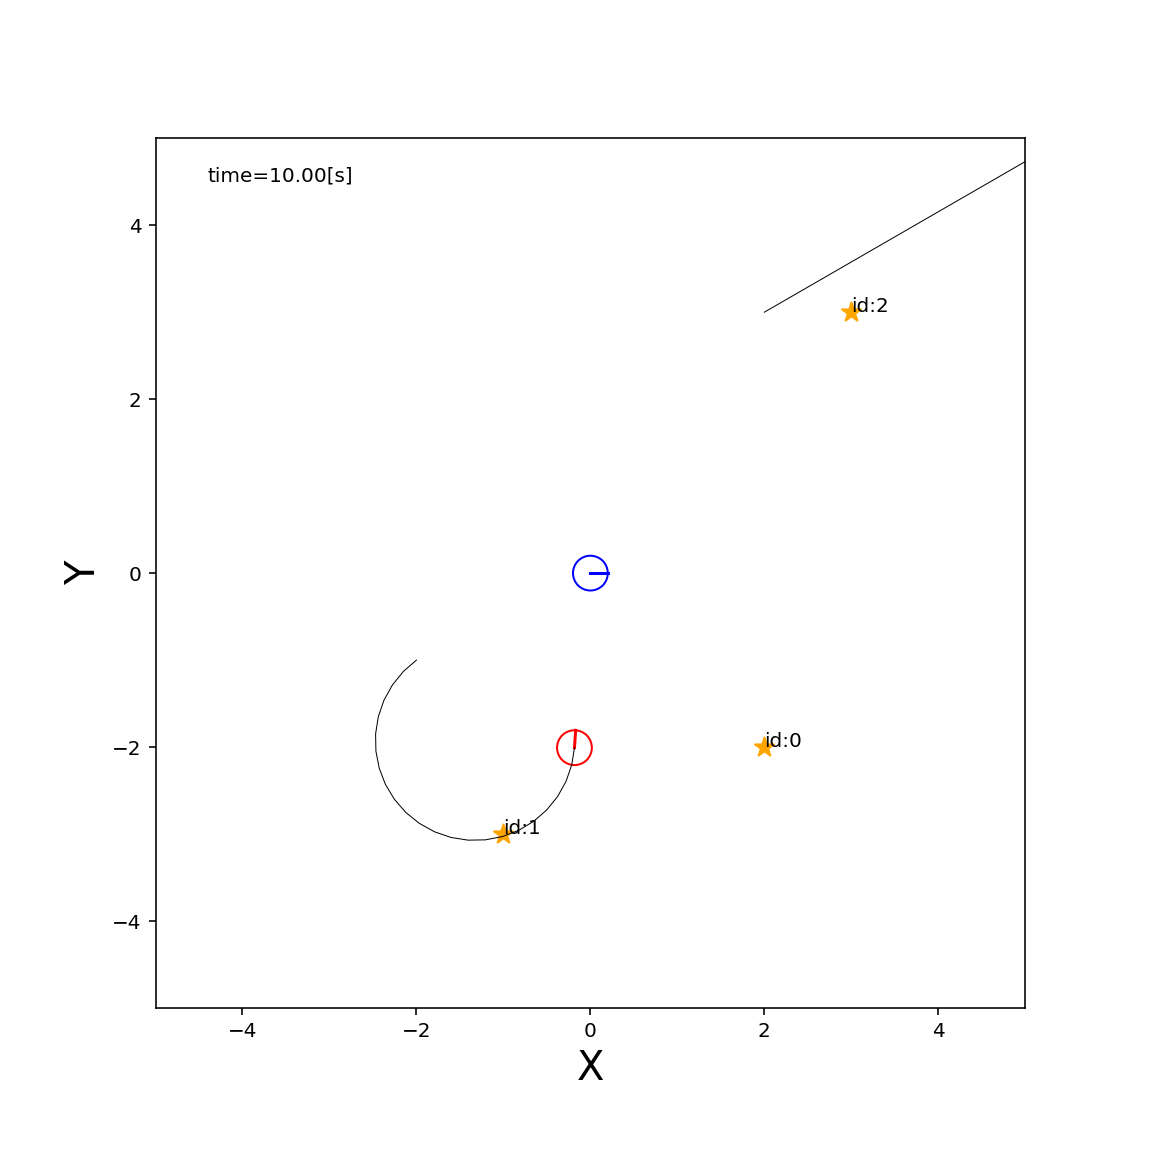

In [79]:
m = Map()
m.append_landmark(Landmark(2, -2))
m.append_landmark(Landmark(-1, -3))
m.append_landmark(Landmark(3,  3))
world.append(m)
world.draw()

## 3.3.2 点ランドマークの観測

ランドマーク $m_j$ のカメラ画像中での大きさと位置から、カメラからの距離 $l_j$ と向き $\phi_j$が計算できることとする。
$l_j, \phi_j$ を合わせて $z_j = (l_j, \phi_j)^\mathrm{T}$ とし、これを「センサ値」と呼ぶ。
時刻 $t$ に得られた複数のセンサ値をまとめて $\mathbf{z}_t$ と表記する。
点ランドマークの座標 $\mathbf{m}_j = (m_{j, x}, m_{j, y})^{\mathrm{T}}$ , ロボットの姿勢 $\mathbf{x} = (x\ y\ \theta)^\mathrm{T}$ から、センサ値 $\mathbf{z}_j = (l_j, \phi_j)^\mathrm{T}$を求める。
$$
    l_j = | m_j - x | = \sqrt{ (m_{j, x} - x )^2 + (m_{j, y} - y )^2}
$$
$\phi_j$ はロボットの向き $\theta$ と $\phi_j$ を足すと
$$
    \phi_j + \theta = \mathrm{atan2}(m_{j, y} - y, m_{j, x} - x)
$$
ここで、
$$
    \mathbf{z}_j = \mathbf{h}(\mathbf{x}, \mathbf{m}_j)
$$
$$
    \mathbf{h}(\mathbf{x}, \mathbf{m}_j) = 
    \left(\begin{array}{cc}
        \sqrt{(m_{j, x} - x )^2 + (m_{j, y} - y )^2} \\
        \mathrm{atan2}(m_{j, y} - y, m_{j, x} - x)
    \end{array}\right)
$$
と表せ、関数 $\mathbf{h}$ を用いた方程式は出力方程式、あるいは観測方程式という名前がついている。

In [82]:
class IdealCamera:
    def __init__(self, env_map):
        self.map = env_map
        
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            p = self.observation_function(cam_pose, lm.pos)
            observed.append((p, lm.id))
        return observed
    
    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        diff = obj_pos - cam_pose[0:2]
        phi = math.atan2(diff[1], diff[0]) - cam_pose[2]
        while phi >= np.pi:
            phi -= 2*np.pi
        while phi < -np.pi:
            phi += 2*np.pi
        return np.array([np.hypot(*diff), phi]).T

In [129]:
cam = IdealCamera(m)
p = cam.data(robot2.pose)
print(p)

[(array([3.91558602, 0.67024454]), 0), (array([0.79296286, 0.38597264]), 1)]


In [142]:
class IdealCamera:
    def __init__(self, env_map, distance_range=(0.5, 6.0), direction_range=(-math.pi/3, math.pi/3)):
        self.map = env_map
        self.lastdata=[]
        
        self.distance_range=distance_range
        self.direction_range=direction_range
        
    def visible(self, polarpos):
        if polarpos is None:
            return False
        return self.distance_range[0] <= polarpos[0] <= self.distance_range[1] \
            and self.direction_range[0] <= polarpos[1] <= self.direction_range[1]
      
    def data(self, cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):
                observed.append((z, lm.id))
        
        self.lastdata=observed
        return observed
    
    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        diff = obj_pos - cam_pose[0:2]
        phi = math.atan2(diff[1], diff[0]) - cam_pose[2]
        while phi >= np.pi:
            phi -= 2*np.pi
        while phi < -np.pi:
            phi += 2*np.pi
        return np.array([np.hypot(*diff), phi]).T
    
    def draw(self, ax, elems, cam_pose):
        for lm in self.lastdata:
            x, y, theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            ly = y + distance * math.sin(direction + theta)
            elems+=ax.plot([x, lx], [y, ly], color="pink")

In [158]:
class IdealRobot:
    def __init__(self, pose, agent=None, sensor=None, color="black"):
        self.pose=pose
        self.r=0.2
        self.color=color
        self.agent=agent
        self.poses=[pose]
        self.sensor=sensor
        
    def draw(self, ax, elems):
        x, y, theta=self.pose
        xn=x + self.r*math.cos(theta)
        yn=y + self.r*math.sin(theta)
        elems += ax.plot([x, xn], [y, yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color)
        elems.append(ax.add_patch(c))
        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
        if self.sensor and len(self.poses) > 1:
            self.sensor.draw(ax, elems, self.pose)
        
    @classmethod
    def state_transition(cls, nu, omega, time, pose):
        t0=pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array([nu*math.cos(t0), 
                                                    nu*math.sin(t0),
                                                   omega] )*time
        else:
            return pose + np.array([
                nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)),
                nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                omega*time
            ])
        
    def one_step(self, time_interval):
        if not self.agent: 
            return
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        if self.sensor: 
                self.sensor.data(self.pose)

<IPython.core.display.Javascript object>


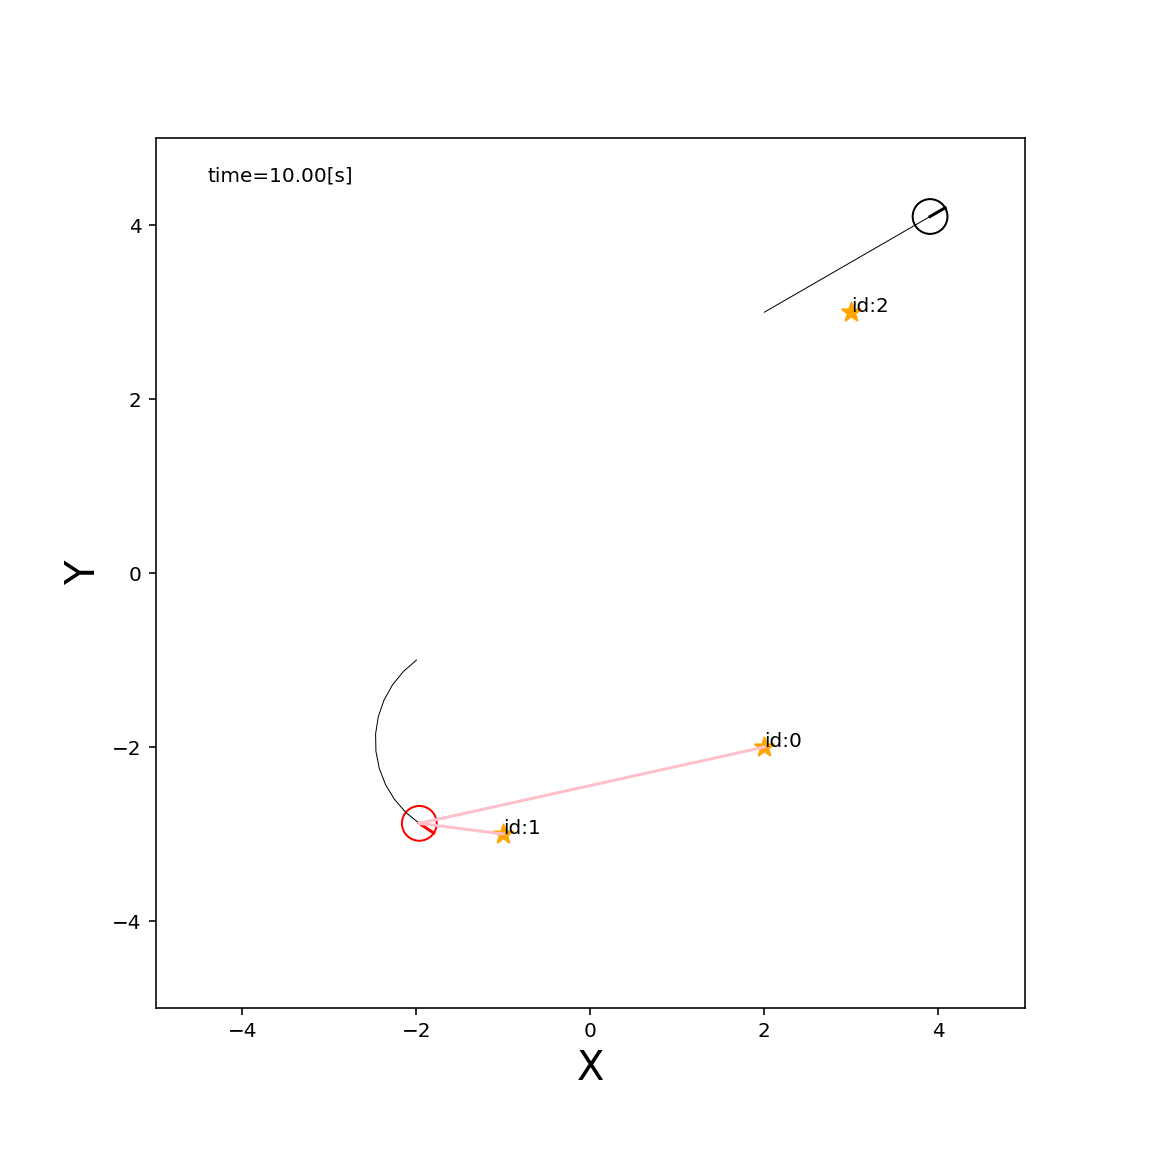

In [159]:
m = Map()
m.append_landmark(Landmark(2, -2))
m.append_landmark(Landmark(-1, -3))
m.append_landmark(Landmark(3,  3))
world=World(10, 1)
straight=Agent(0.2, 0.0)
circling=Agent(0.2, 10.0/180*math.pi)
robot1=IdealRobot(np.array([2, 3, math.pi/6]).T, sensor=IdealCamera(m), agent=straight)
robot2=IdealRobot(np.array([-2, -1, math.pi/5*6]).T, sensor=IdealCamera(m), agent=circling, color="red")
world.append(m)
world.append(robot1)
world.append(robot2)
world.draw()

# 3.4 コードの保存と再利用

In [161]:
import sys
sys.path.append('./scripts/')
from ideal_robot import *